In [269]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from tqdm import tqdm

In [280]:
class Particle:
    
    def __init__(self, r0, v0, a0, t, m=1, radius=2., Id=0):
        
        self.dt = t[1] - t[0]
        
        
        # Atributos instantaneos
        self.r = r0
        self.v = v0
        self.a = a0
        
        self.m = m
        self.radius = radius
        self.Id = Id
        
        
        self.p = self.m*self.v
        self.l = np.cross(self.r,self.m*self.v)
        
        self.f = self.m*self.a
        
        # Historial
        
        self.R = np.zeros((len(t),len(r0)))
        self.V = np.zeros_like(self.R)
        self.A = np.zeros_like(self.R)
        
        self.F = np.zeros_like(self.R)
        
        self.P = np.zeros_like(self.R)
        self.L = np.zeros_like(self.R)
    
        # Fisica
        self.K = 20.
        
        self.Ep = 0.
        self.VEk = np.zeros(len(t))
        self.VEp = np.zeros(len(t))
        
    def Evolution(self,i):
        
        
        self.SetPosition(i)
        self.SetVelocity(i)
        self.SetAngularMomentum(i)
        self.SetPotential(i)
        
        self.a = self.f/self.m
        
        # Euler
        #self.r += self.dt*self.v
        #self.v += self.dt*self.a
        
        #Euler-Cromer
        self.v += self.dt*self.a
        self.r += self.dt*self.v
        
        
    def CalculateForce(self,p):
        
        d = np.linalg.norm(self.r - p.r)
        
        compresion = self.radius + p.radius - d
        
        if compresion >= 0:
            
            Fn = self.K * compresion**3
            
            self.n = (self.r - p.r)/d     
            self.f = np.add(self.f,Fn*self.n)
            # Falta implementar energía potencial 
            self.Ep += (1/4)*self.K*compresion**4
            
            
    def SetPotential(self,i):
        self.VEp[i] = self.Ep
            
    # Aca debes agregar la energía potencial
    def ResetForce(self):
        self.f[:] = 0.
        self.a[:] = 0.
        self.Ep = 0.
    
    # Setter
    def SetPosition(self,i):
        self.R[i] = self.r
    
    def SetVelocity(self,i):
        self.V[i] = self.v
        self.P[i] = self.m*self.v
        
        self.VEk[i] = 0.5*self.m*np.dot(self.v,self.v)
        
    def SetAngularMomentum(self,i):
        self.L[i] = np.cross(self.r,self.m*self.v)
        
    # Getter
    def GetPosition(self,scale=1):
        return self.R[::scale]
    
    def GetVelocity(self,scale=1):
        return self.V[::scale]
 
    def GetMomentum(self,scale=1):
        return self.P[::scale]
    
    def GetAngularMomentum(self,scale=1):
        return self.L[::scale]
    
    def GetKineticEnergy(self,scale=1):
        return self.VEk[::scale]
    
    def GetPotentialEnergy(self,scale=1):
        return self.VEp[::scale]
    
    # Debes agregar las paredes en este punto

In [281]:
def GetParticles(N,t):
    
    Particles = []
    
    for i in range(N):
        r = np.random.uniform(-20,20,size=2)
        v = np.random.uniform(-5,5,size=2)
        a = np.array([0.,0.])
        
        p = Particle(r,v,a,t,m=1,radius=2,Id=i)
        Particles.append(p)
    
    return Particles

In [282]:
dt = 0.001
tmax = 10
t = np.arange(0,tmax,dt)
Particles = GetParticles(10,t)

In [283]:
def RunSimulation(t,Particles):
    
    for it in tqdm(range(len(t)), desc='Running simulation', unit=' Steps' ):
        
        for i in range(len(Particles)):
            for j in range(len(Particles)):
                if i!=j:
                    Particles[i].CalculateForce(Particles[j])
        
        for i in range(len(Particles)):
            Particles[i].Evolution(it)
            Particles[i].ResetForce()
            # Aca debes agregar la interaccion con la pared
            
            
    return Particles

In [284]:
Particles = RunSimulation(t,Particles)

Running simulation: 100%|███████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 376.40 Steps/s]


In [285]:
# Bajamos dimensión de la simulacion
scale = 200
t1 = t[::scale]

<IPython.core.display.Javascript object>


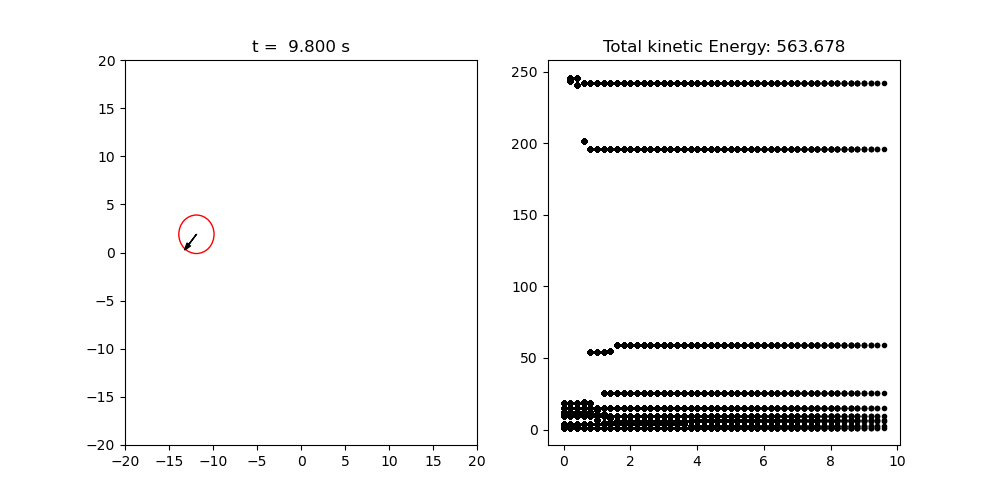

In [286]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

def init():
    
    ax.clear()
    ax.set_xlim(-20,20)
    ax.set_ylim(-20,20)
    
def Update(i):
    
    init()
    ax.set_title(r't =  %.3f s' %(t1[i]))
    
    
    # Queremos calcular la energía total de cinética
    KE = 0. # Kinetic energy
    
    for p in Particles:
        
        x = p.GetPosition(scale)[i,0]
        y = p.GetPosition(scale)[i,1]
        
        vx = p.GetVelocity(scale)[i,0]
        vy = p.GetVelocity(scale)[i,1]
        
        circle = plt.Circle( (x,y), p.radius, color='r', fill=False )
        ax.add_patch(circle)
        
        ax.arrow(x,y,vx,vy,color='k',head_width=0.5,length_includes_head=True)
        
        KE += p.GetKineticEnergy(scale)[i]
        
        ax1.set_title(r'Total kinetic Energy: {:.3f}'.format(KE))
        ax1.scatter(t1[:i], p.GetKineticEnergy(scale)[:i],color='k',marker='.')
        
Animation = anim.FuncAnimation(fig,Update,frames=len(t1),init_func=init)

In [287]:
MomentumT = Particles[0].GetMomentum(scale)

In [288]:
for i in range(1,len(Particles)):
    MomentumT = np.add(MomentumT,Particles[i].GetMomentum(scale))

<IPython.core.display.Javascript object>


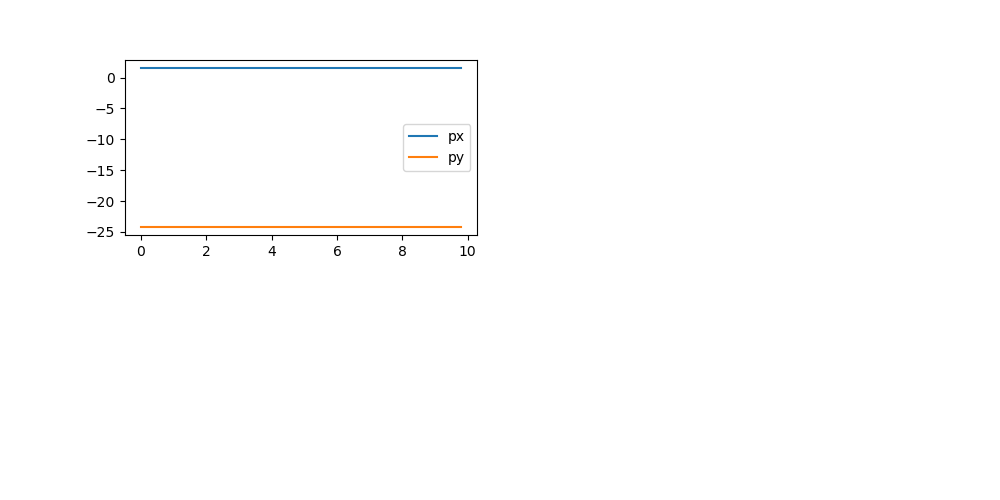

In [289]:
fig3 = plt.figure(figsize=(10,5))
ax3 = fig3.add_subplot(221)
ax3.plot(t1,MomentumT[:,0],label='px')
ax3.plot(t1,MomentumT[:,1],label='py')
ax3.legend()

<IPython.core.display.Javascript object>


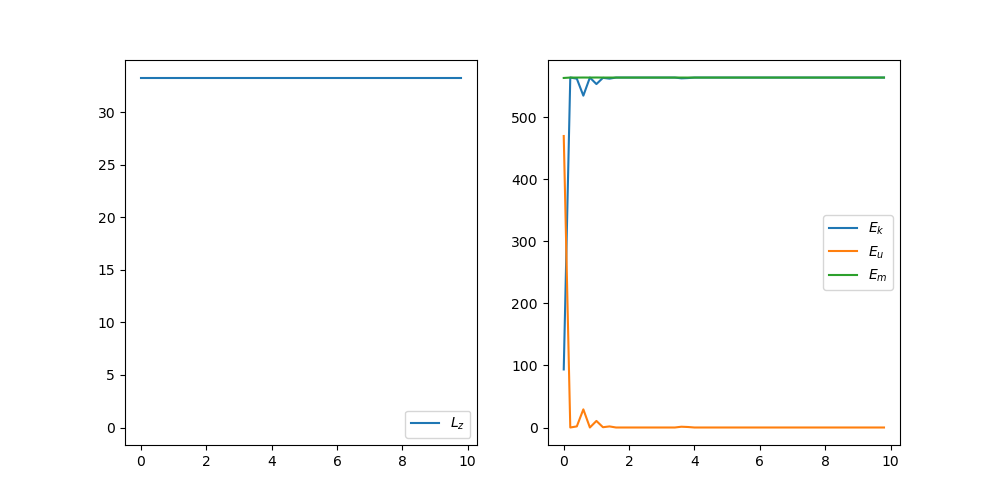

In [292]:
AngularT = Particles[0].GetAngularMomentum(scale)
KineticT = Particles[0].GetKineticEnergy(scale)
PotentialT = Particles[0].GetPotentialEnergy(scale)/2

for i in range(1,len(Particles)):
    AngularT = np.add(AngularT1,Particles[i].GetAngularMomentum(scale))
    KineticT = np.add(KineticT,Particles[i].GetKineticEnergy(scale))
    PotentialT = np.add(PotentialT,Particles[i].GetPotentialEnergy(scale)/2)
    
MecanicaT = PotentialT + KineticT
    
fig4 = plt.figure(figsize=(10,5))
ax4 = fig4.add_subplot(121)
ax5 = fig4.add_subplot(122)

#ax4.plot(t1,AngularT,label='Lz')
ax4.plot(t1,AngularT1[:,0],label="$L_z$")
ax4.plot(0,0)

ax5.plot(t1,KineticT,label='$E_k$')
ax5.plot(t1,PotentialT,label='$E_u$')
ax5.plot(t1,MecanicaT,label='$E_m$')

ax4.legend()
ax5.legend()